The main question is whether reporting sex in the paper is associated with more citations. 

# Modules and setup

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import scipy.stats as stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

# Multi-author data

## Data preparation

Let's first look at the multi-author data. 

In [2]:
df = pd.read_csv('../data/multi_author_final.csv')
df.GENDER_TOPIC.replace('N', 'A', inplace=True)  # a hack to make 'none' and 'male' as the pivot target
df.head(2)

,PID,YEAR,MAIN_COUNTRY,N_AUTHORS,N_ADDRESSES,N_REFS,VENUE,IF,N_CITATIONS,GENDER_TOPIC,...,FEMALE_FRACTION,MALE_FRACTION,DISCIPLINE,SUBDISCIPLINE,COUNTRY,CONTINENT,F_FIRST_MESH,F_LAST_MESH,F_FIRST_MAIN_COUNTRY,F_LAST_MAIN_COUNTRY
0,29496694,2008,United States,5,1,14,ADVANCES IN EXPERIMENTAL MEDICINE AND BIOLOGY,1.059,5,A,...,0.200,0.800,Biomedical Research,Biochemistry & Molecular Biology,United States,Northern America,0.526,0.363,0.416,0.285
1,29503162,2008,Netherlands,5,3,49,EXPERIMENTAL BRAIN RESEARCH,1.812,81,B,...,0.400,0.600,Clinical Medicine,Neurology & Neurosurgery,Netherlands,Europe,0.490,0.326,0.536,0.272


I think the easiest way to control the citation year is simply splitting the data by year and run regression separately. Let's see the year range. 

In [3]:
df.columns

Index(['PID', 'YEAR', 'MAIN_COUNTRY', 'N_AUTHORS', 'N_ADDRESSES', 'N_REFS',
       'VENUE', 'IF', 'N_CITATIONS', 'GENDER_TOPIC', 'GENDER_FIRST',
       'GENDER_LAST', 'FEMALE_FRACTION', 'MALE_FRACTION', 'DISCIPLINE',
       'SUBDISCIPLINE', 'COUNTRY', 'CONTINENT', 'F_FIRST_MESH', 'F_LAST_MESH',
       'F_FIRST_MAIN_COUNTRY', 'F_LAST_MAIN_COUNTRY'],
      dtype='object')

In [4]:
df['F_MESH'] = (df['F_FIRST_MESH'] + df['F_LAST_MESH']) / 2.0
df['F_COUNTRY'] = (df['F_FIRST_MAIN_COUNTRY'] + df['F_LAST_MAIN_COUNTRY'])/2.0

In [5]:
df.YEAR.value_counts()

2015    268882
2014    266412
2013    258997
2012    238043
2011    220684
2010    207128
2009    191914
2008    186854
2016    179783
Name: YEAR, dtype: int64

We can probably use 2008-2015 data. 

## Regression on the whole dataset

In [6]:
def coeffs_and_errs(reg_result, IVs):
    coeffs = [reg_result.params[iv] for iv in IVs]
    err_l = [reg_result.params[iv] - reg_result.conf_int().loc[iv][0] for iv in IVs]
    err_u = [reg_result.conf_int().loc[iv][1] - reg_result.params[iv] for iv in IVs]
    return coeffs, err_l, err_u

def plot_coeffs(results, years, IVs, labels, 
                height_each=0.15, mingrey=0.8, maxgrey=0.0, elinewidth=1, markersize=2.5):
    assert len(results) == len(years)
    nyears = len(years)
    offsets = np.linspace(-height_each, height_each, num=nyears)
    colors = np.linspace(mingrey, maxgrey, num=nyears)

    Y = np.arange(1, len(IVs)+1)

    fig, ax = plt.subplots()
    fig.set_size_inches(5,4)

    handles = []
    for idx, result in enumerate(results):
        coeffs, err_l, err_u = coeffs_and_errs(result, IVs)
        h = ax.errorbar(coeffs, Y-offsets[idx], xerr=[err_l, err_u], fmt='o', 
                        color=str(colors[idx]), elinewidth=elinewidth, markersize=markersize)    
        handles.append(h)


    [ax.axhline(y+0.5, color="0.95", linewidth=0.5) for y in Y[:-1]]
    ax.legend(handles, years)
    plt.axvline(x=0, color='r', linewidth=0.5)

    plt.xlabel("Coefficients with 95% CI")
    plt.yticks(y, labels, rotation='horizontal')
    plt.tight_layout()
    fig.savefig('cit_multiauthor_alldisc_by_year.pdf')

In [7]:
IF_model = ('IF ~ GENDER_TOPIC + GENDER_FIRST + GENDER_LAST '
            '+ np.log2(N_AUTHORS) + CONTINENT + SUBDISCIPLINE')
result = smf.ols(IF_model, data=df[df.YEAR==2008]).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     IF   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     517.6
Date:                Tue, 06 Nov 2018   Prob (F-statistic):               0.00
Time:                        10:32:40   Log-Likelihood:            -4.1397e+05
No. Observations:              175134   AIC:                         8.281e+05
Df Residuals:                  175066   BIC:                         8.288e+05
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    0.5507      0.122      4.509      0.000       0.311       0.790
GENDER_TOPIC[T.B]                                           -0.4702      0.017    -28.452      0.000      -0.503      -0.438
GENDER_TOPIC[T.F]                                           -0.5455      0.022    -24.492      0.000      -0.589      -0.502
GENDER_TOPIC[T.M]                                           -0.4603      0.021    -21.613      0.000      -0.502      -0.419
GENDER_FIRST[T.M]                                            0.0823      0.013      6.356      0.000       0.057       0.108
GENDER_LAST[T.M]                                             0.1098      0.014      7.578      0.000       0.081       0.138
CONTINENT[T.Asia]                                            0.0488      0.095      0.516      0.606      -0.137       0.234
CONTINENT[T.Europe]                                          0.5951      0.094      6.328      0.000       0.411       0.779
CONTINENT[T.Northern America]                                1.3056      0.094     13.908      0.000       1.122       1.490
CONTINENT[T.Oceania]                                         0.8748      0.100      8.736      0.000       0.679       1.071
CONTINENT[T.South America]                                  -0.0988      0.101     -0.983      0.326      -0.296       0.098
SUBDISCIPLINE[T.Allergy]                                     1.2304      0.153      8.058      0.000       0.931       1.530
SUBDISCIPLINE[T.Anatomy & Morphology]                       -0.3590      0.181     -1.986      0.047      -0.713      -0.005
SUBDISCIPLINE[T.Anesthesiology]                             -0.1889      0.117     -1.608      0.108      -0.419       0.041
SUBDISCIPLINE[T.Arthritis & Rheumatology]                    0.9227      0.107      8.592      0.000       0.712       1.133
SUBDISCIPLINE[T.Biochemistry & Molecular Biology]            1.6815      0.079     21.328      0.000       1.527       1.836
SUBDISCIPLINE[T.Biomedical Engineering]                      0.4144      0.092      4.504      0.000       0.234       0.595
SUBDISCIPLINE[T.Biophysics]                                  0.5514      0.108      5.097      0.000       0.339       0.763
SUBDISCIPLINE[T.Cancer]                                      1.5373      0.080     19.098      0.000       1.380       1.695
SUBDISCIPLINE[T.Cardiovascular System]                       1.1411      0.082     13.915      0.000       0.980       1.302
SUBDISCIPLINE[T.Cellular Biology Cytology & Histology]       2.2174      0.086     25.911      0.000       2.050       2.385
SUBDISCIPLINE[T.Dentistry]                                  -0.3084      0.095     

## IF model

In [8]:
years = [2008, 2010, 2012, 2014, 2016]
IF_model = 'IF ~ GENDER_TOPIC + GENDER_FIRST + GENDER_LAST ' \
           '+ np.log2(N_AUTHORS) + SUBDISCIPLINE + CONTINENT'

IF_model = ('IF ~ GENDER_TOPIC + GENDER_FIRST + GENDER_LAST '
            '+ np.log2(N_AUTHORS) + CONTINENT + SUBDISCIPLINE')


IF_results_all = [smf.ols(IF_model, data=df[df.YEAR==year]).fit() for year in years]
IF_results_b = [smf.ols(IF_model, data=df[(df.YEAR==year) & (df.DISCIPLINE=='Biomedical Research')]).fit() 
               for year in years]
IF_results_c = [smf.ols(IF_model, data=df[(df.YEAR==year) & (df.DISCIPLINE=='Clinical Medicine')]).fit() 
               for year in years]
IF_results_h = [smf.ols(IF_model, data=df[(df.YEAR==year) & (df.DISCIPLINE=='Health')]).fit() 
               for year in years]

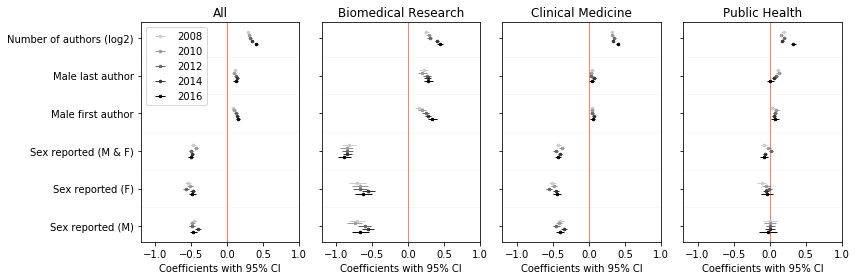

In [13]:
IVs = ['GENDER_TOPIC[T.M]', 'GENDER_TOPIC[T.F]', 'GENDER_TOPIC[T.B]', 'GENDER_FIRST[T.M]', 
       'GENDER_LAST[T.M]', 'np.log2(N_AUTHORS)']
labels = ['Sex reported (M)', 'Sex reported (F)', 'Sex reported (M & F)', 'Male first author', 'Male last author', 
              'Number of authors (log2)']

def plot_coeffs_on_ax(ax, title, results, years, IVs, labels, xlim=(None, None), legend=True, 
                height_each=0.15, mingrey=0.8, maxgrey=0.0, elinewidth=1, markersize=2.5):
    assert len(results) == len(years)
    nyears = len(years)
    offsets = np.linspace(-height_each, height_each, num=nyears)
    colors = np.linspace(mingrey, maxgrey, num=nyears)

    Y = np.arange(1, len(IVs)+1)
    
    handles = []
    for idx, result in enumerate(results):
        coeffs, err_l, err_u = coeffs_and_errs(result, IVs)
        h = ax.errorbar(coeffs, Y-offsets[idx], xerr=[err_l, err_u], fmt='o', 
                        color=str(colors[idx]), elinewidth=elinewidth, markersize=markersize)    
        handles.append(h)


    ax.set_title(title)
    [ax.axhline(y+0.5, color="0.95", linewidth=0.5) for y in Y[:-1]]
    if legend:
        ax.legend(handles, years)
    ax.axvline(x=0, color='r', linewidth=0.5)
    ax.set_xlim(xlim)
    ax.set_xlabel("Coefficients with 95% CI")

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
fig.set_size_inches(12,4)
fig.subplots_adjust(wspace=0)
xlim = (-1.2, 1.0)

y = list(range(1, 7))
plot_coeffs_on_ax(ax1, "All", IF_results_all, years, IVs, labels, xlim=xlim, legend=True)
plt.yticks(y, labels, rotation='horizontal')

plot_coeffs_on_ax(ax2, "Biomedical Research", IF_results_b, years, IVs, labels, xlim=xlim, legend=False)
plot_coeffs_on_ax(ax3, "Clinical Medicine", IF_results_c, years, IVs, labels, xlim=xlim, legend=False)
plot_coeffs_on_ax(ax4, "Public Health", IF_results_h, years, IVs, labels, xlim=xlim, legend=False)


plt.tight_layout()
fig.savefig('IF_multiauthor_by_year.pdf')

In [10]:
for i, result_set in enumerate([IF_results_all, IF_results_b, IF_results_c, IF_results_h]):
    for j, result in enumerate(result_set):
        open(f'{i}_{j}.csv', 'w').write(result.summary().as_csv())

In [11]:
r = IF_results_all[0]

In [12]:
def make_table(r):
    IVs = ['Intercept', 'GENDER_TOPIC[T.B]', 'GENDER_TOPIC[T.F]', 'GENDER_TOPIC[T.M]', 
           'GENDER_FIRST[T.M]', 'GENDER_LAST[T.M]', 'np.log2(N_AUTHORS)']
           
    labels = ['Intercept', 'Sex reported (M & F)', 'Sex reported (F)', 'Sex reported (M)',
              'Male first author', 'Male last author', 'Number of authors (log2)',
              'Adjusted R-squared', 'No. Observations']

    def coeff_str(result, iv):
        template = '{:.2} ({:.2f}, {:.2f})'
        return template.format(result.params[iv],
                               result.conf_int()[0][iv],
                               result.conf_int()[1][iv])

    years = [2008, 2011, 2014]
    tempdf= pd.DataFrame({'Variables': labels, 
                           '2008': [coeff_str(r[0], x) for x in IVs] +\
                                                    ['{:.2f}'.format(r[0].rsquared_adj), 
                                                     '{:.2f}'.format(r[0].nobs)], 
                          '2011': [coeff_str(r[1], x) for x in IVs] +\
                                                    ['{:.2f}'.format(r[1].rsquared_adj), 
                                                     '{:.2f}'.format(r[1].nobs)], 
                          '2014': [coeff_str(r[2], x) for x in IVs] +\
                                                    ['{:.2f}'.format(r[2].rsquared_adj), 
                                                     '{:.2f}'.format(r[2].nobs)], 
                         }, columns=['Variables', '2008', '2011', '2014'])

    return tempdf

make_table(IF_results_h).to_csv('temp.csv', index=False)